<a href="https://colab.research.google.com/github/gmit22/LifeHack-2020/blob/master/Image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import os
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.utils import shuffle
import imutils

In [2]:
dir = os.path.join(os.getcwd(), "drive/My Drive/data")

In [3]:
def loadData(dir):

    images = []
    category = []
    file_dir = []

    for img in os.listdir(dir):

        if img.endswith(".png"):
        #images.append(cv2.imread(os.path.join(dir, img)))
            file_dir.append(os.path.join(dir, img))

            if img.startswith('NL'):      #assigning label to file according to          
                category.append(0)             # their type

            elif img.startswith('ca'):    
                category.append(1)

            elif img.startswith('Gl'):  
                category.append(2)

            elif img.startswith('Re'):          
                category.append(3)

    file_dir = np.array(file_dir)
    category = np.array(category, dtype = 'int32')  

    return shuffle(file_dir, category,random_state=817328462)


In [4]:
file_dir, category = loadData(dir)

In [5]:
print(len(file_dir))

601


In [6]:
def get_label(encoded_val):
      
      labels = {0:'normal', 1:'cataract', 2:'glaucoma', 3:'retina'}
      return labels[class_code]

In [7]:
def data_augment(file_dir, labels):

    img_set = []
    lbl_set = []

    for i in range(len(file_dir)):


        label = labels[i]
        img = get_object(file_dir[i])

        flip_v = cv2.flip(img,0) #vertical flip
        flip_h = cv2.flip(img,1) #lr flip

        img_set.append(img)
        img_set.append(flip_v)
        img_set.append(flip_h)

        lbl_set.append(label)
        lbl_set.append(label)
        lbl_set.append(label)

    return (np.array(img_set),np.array(lbl_set))


In [8]:
def get_object(filename):

    image = cv2.imread(filename)
    im_size = 512
    
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) # convert 2 grayscale

    retval, threshold = cv2.threshold(gray,10,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(threshold,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) # find contours

    # ensure at least some circles were found
    if contours:

        contours = sorted(contours, key=cv2.contourArea, reverse=True) 

        #find the bounding rect
        x,y,w,h = cv2.boundingRect(contours[0])                  
        img = image[y:y+h,x:x+w]# crop image

        resize=cv2.resize(img,(im_size,im_size)) # resize to im_size X im_size size
        
        return resize

    return cv2.resize(image, (im_size,im_size))

In [9]:
X, y = data_augment(file_dir, category)

Rotates the images 

<class 'numpy.ndarray'>


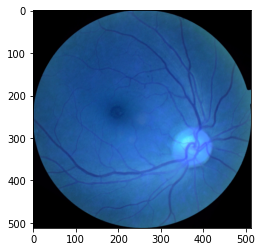

In [35]:
im = X[0]
image = imutils.rotate(im, angle=-30) 
print(type(image))
plt.imshow(image)
plt.show()